In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Krylov as K

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In this notebook I discuss the Lanczos procedure for a symmetric matrix $H$. Starting from $H$ and given an arbitrary vector
$u_0$ I build the Krylov space and compute the tridiagonal symmetric matrix $T$ that represents the $H$ matrix expressed in the Krilov base. Then I compute the diagonal matrix element of the resolvent of $H$ on $u_{0}$.

I start by building an arbitrary symmetric matix and a normalized column vector

In [2]:
n=100
M=np.matrix(np.random.rand(n*n).reshape(n,n))
H = M + M.T
u0 = np.matrix(np.random.rand(n).reshape(n,1))
u0norm = K.norm(u0)
u0=u0/u0norm
K.norm(u0)

0.99999999999999978

Now I compute the resolvent of $H$ on $u_{0}$ by using the standard spectral representation of $H$
$$ G(z) = \langle u_{0} | \frac{1}{z-H} | u_{0} \rangle = \sum_{v=1}^{n} \frac{ \langle u_{0} | v \rangle \langle v | u_{0} \rangle }{z-E_v}
$$
where $|v \rangle$ are the eigenvectors of H.

In [3]:
e,w = np.linalg.eigh(H)
#e

In [4]:
K.validate_eigensystem(H,e,w)

Validation terminated


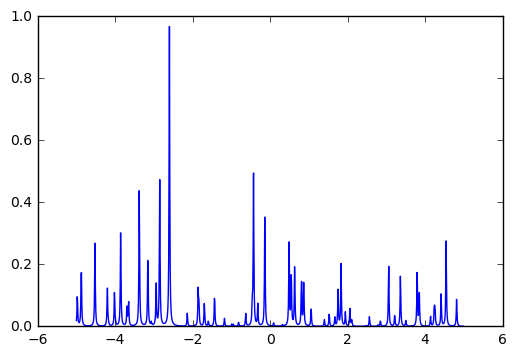

In [5]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,K.resolvent(u0,e,w,x))

Now I want to reproduce this result using the Lanczos procedure. The Krylov space $|\phi_{n}\rangle$ is generated by the repeated action of $H$ on a the given (normalized) vector $u_{0}$. The elements of the space satisfy the relation:

$$
H|\phi_{n} \rangle = \beta_{n}|\phi_{n-1}\rangle + \alpha_{n}|\phi_{n}\rangle + \beta_{n+1}|\phi_{n+1}\rangle
$$

I define the routine that generates the Krylov spaces and computes the coefficients $\alpha$ and $\beta$.
The first step of the procedure $(dimKrylov=1)$ is given by:

$$
|\phi_{0}\rangle = |u_{0}\rangle \; , \quad \alpha_{0} = \langle u_{0}|H|u_{0}\rangle \; , \quad \beta_{0} = 0 \; , \quad
\beta_{1} = ||(H-\alpha_{0})|u_{0}\rangle ||
$$

The second step of the procedure $(dimKrylov=2)$ takes $|\phi_{0}\rangle,\alpha_{0},\beta_{1},\beta_{0}=0$ as input and returns $|\phi_{1}\rangle,\alpha_{1},\beta_{2}$ according to:

$$
|\phi_{1}\rangle = \frac{(H-\alpha_{0})|\phi_{0}\rangle}{\beta_{1}} \; , \quad \alpha_{1} = \langle \phi_{1}|H|\phi_{1}\rangle \; ,  \quad \beta_{2} = ||(H-\alpha_{1})|\phi_{1}\rangle-\beta_{1}|\phi_{0}\rangle || 
$$

The third step of the procedure $(dimKrylov=3)$ takes $|\phi_{1}\rangle,\phi_{0}\rangle,\alpha_{1},\beta_{2},\beta_{1}$ as input and returns $|\phi_{2}\rangle,\alpha_{2},\beta_{3}$ according to:

$$
|\phi_{2}\rangle = \frac{(H-\alpha_{1})|\phi_{1}\rangle-\beta_{1}|\phi_{0}\rangle}{\beta_{2}} \; , \quad \alpha_{2} = \langle \phi_{2}|H|\phi_{2}\rangle \; ,  \quad \beta_{3} = ||(H-\alpha_{2})|\phi_{2}\rangle-\beta_{2}|\phi_{1}\rangle || 
$$

The generic step takes $|\phi_{s}\rangle,|\phi_{s-1}\rangle,\alpha_{s},\beta_{s+1}\beta_{s}$ as input and gives $|\phi_{s+1}\rangle,\alpha_{s+1},\beta_{s+2}$ according to the formula:

$$
|\phi_{s+1}\rangle = \frac{(H-\alpha_{s})|\phi_{s}\rangle-\beta_{s}|\phi_{s-1}\rangle}{\beta_{s+1}} \; , \quad
\alpha_{s+1} = \langle \phi_{s+1}|H|\phi_{s+1}\rangle \; , \quad
\beta_{s+2} = ||(H-\alpha_{s+1})|\phi_{s+1}\rangle-\beta_{s+1}|\phi_{s}\rangle||
$$

I define the routine that perform the generic step of the recursion

I perform the recursion until the Krylov space reaches a given dimension

In [6]:
reload(K)
KL=K.KrylovLoop(100,H,u0)
KL.iterate()

In [7]:
#print(alpha)
#print(beta)
#print(krylov)

I compute $H$ in the basis of the krylov vectors and verify if it is a tridiagonal matrix $T$ with elements given by
$\alpha$ and $\beta$ parameters. (There are known problems of orthonormality in the Krylov space)

In [8]:
Hkrylov = np.matmul(KL.krylov.T,H.dot(KL.krylov))

Up = np.matrix(np.zeros(KL.dimKrylov**2).reshape(KL.dimKrylov,KL.dimKrylov))
T = np.matrix(np.diag(KL.alpha))
for i in range(KL.dimKrylov-1):
    Up[i,i+1] = KL.beta[i+1]
T += Up + Up.T
T

np.allclose(np.ravel(Hkrylov),np.ravel(T),atol=1.e-10)
#T

False

Now that the tridiagonal matrix has been built $G(z)$ can be computed in term of a ratio of determinants or as a continuum fraction. Written as a ratio of determinants we have:
$$
G(z) = \frac{D_{1}(z)}{D_{0}(z)}
$$
where $D_{0}(z)$ is the determinant of $z-T$ and $D_{1}(z)$ is the determinant of the submatrix obtained by removing the first row and column from $z-T$. 

In [9]:
reload(K)

<module 'Krylov' from 'Krylov.pyc'>

In [10]:
def D(i,H,omega,eta=1.e-2):
    DimH = len(H)
    Hsub = H[i:DimH,i:DimH]
    dimHsub = len(Hsub)
    Di = (omega+1j*eta)*np.eye(dimHsub)-Hsub
    Didet = np.linalg.det(Di)
    return Didet

In [11]:
def G(H,omega,eta=1.e-2):
    D0det = D(0,H,omega,eta)
    D1det = D(1,H,omega,eta)
    ratio = D1det/D0det
    out = -1/np.pi*ratio.imag
    return out

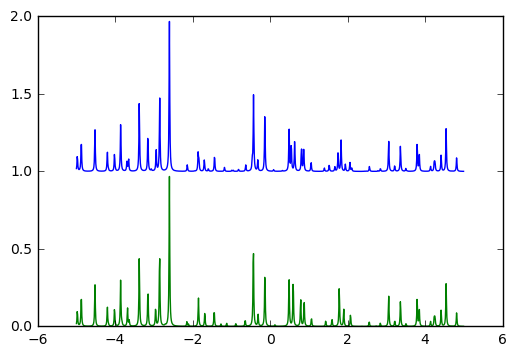

In [12]:
x=np.arange(-5.0, 5.0, 0.01)
y=[K.G(T,val) for val in x]
plt.plot(x,1+K.resolvent(u0,e,w,x))
plt.plot(x,y)
plt.show()

Lastly, I implement $G(z)$ as a continued fraction. I use a modified version of the analysis discussed in 
https://rosettacode.org/wiki/Continued_fraction#Python. Here I present a generic implementation and some notable results

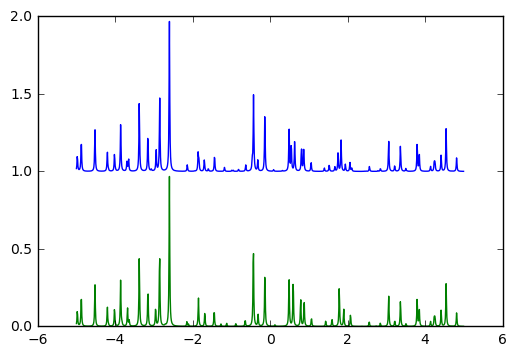

In [13]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,1+K.resolvent(u0,e,w,x))
plt.plot(x,K.Gfrac(KL.alpha,KL.beta,x))
plt.show()